In [1]:
%load_ext autoreload
%autoreload 2

from tools import *
from models import *

from keras import optimizers
from keras.models import load_model
from keras.callbacks import *
import keras

from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt

import numpy as np
import os
import random

tf.test.is_built_with_cuda()
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [20]:
X_train, y_train, y_train_steer = load_data()

print(f"Images: {len(X_train)}")
print(f"Controls: {len(y_train)}")
print(f"Steers: {len(y_train_steer)}\n")

steer_count = 0
for steer in y_train_steer:
    steer_count += steer.item()
print(f"Should Steers: {steer_count}")

input_shape = X_train[0].shape
print("Input shape: " + str(input_shape))

Loading data

Finished loading data

Images: 2958
Controls: 2958
Steers: 2958

Should Steers: 184
Input shape: (120, 160, 3)


Frame: 843
Control: [ 0.69999999 -0.30000001]
Steer: [1]


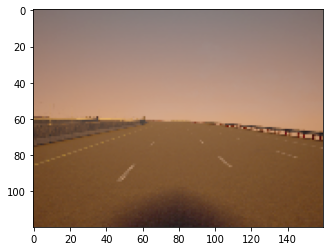

In [3]:
FRAME = random.randint(1, 2000)

show_image(X_train[FRAME])
print(f"Frame: {FRAME}")
print(f"Control: {y_train[FRAME]}")
print(f"Steer: {y_train_steer[FRAME]}")

In [16]:
# Stops training early when no improvement for monitor value
early_stop = EarlyStopping(monitor="val_loss", 
                           min_delta=0, 
                           patience=10, 
                           verbose=1)

# Reduces learning rate when monitor value plateaus
reduce_lr = ReduceLROnPlateau(monitor="val_loss", 
                              factor=0.316, 
                              patience=5, 
                              verbose=1)

cb_list = [early_stop, reduce_lr]

In [17]:
keras.backend.clear_session()

# model = ImiCarla(input_shape=input_shape)
steer_model = ImiSteer(input_shape=input_shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 160, 32)      4736      
_________________________________________________________________
batch_normalization (BatchNo (None, 120, 160, 32)      128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 120, 160, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 80, 32)        0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 60, 80, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 80, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 80, 64)        2

In [18]:
steer_optim = optimizers.Adam(learning_rate=0.001)
steer_model.compile(steer_optim, loss="binary_crossentropy")

In [19]:
steer_history = steer_model.fit(x=X_train, 
                                y=y_train_steer, 
                                batch_size=8, 
                                epochs=100, 
                                verbose=1, 
                                validation_split=0.2, 
                                shuffle=True,
                                callbacks=cb_list)

Epoch 1/100
296/296 [==============================] - 6s 22ms/step - loss: 0.3218 - val_loss: 0.4340
Epoch 2/100
296/296 [==============================] - 6s 21ms/step - loss: 0.2677 - val_loss: 0.2150
Epoch 3/100
296/296 [==============================] - 6s 21ms/step - loss: 0.2512 - val_loss: 0.2282
Epoch 4/100
296/296 [==============================] - 6s 21ms/step - loss: 0.2465 - val_loss: 0.2060
Epoch 5/100
296/296 [==============================] - 6s 21ms/step - loss: 0.2472 - val_loss: 0.2037
Epoch 6/100
296/296 [==============================] - 6s 21ms/step - loss: 0.2475 - val_loss: 0.2079
Epoch 7/100
296/296 [==============================] - 6s 21ms/step - loss: 0.2456 - val_loss: 0.2312
Epoch 8/100
296/296 [==============================] - 6s 21ms/step - loss: 0.2413 - val_loss: 0.2091
Epoch 9/100
296/296 [==============================] - 6s 21ms/step - loss: 0.2446 - val_loss: 0.2004
Epoch 10/100
296/296 [==============================] - 6s 21ms/step - loss: 0.242

KeyboardInterrupt: 

In [ ]:
plt.plot(steer_history.history["loss"])
plt.plot(steer_history.history["val_loss"])
plt.title("Steer Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="upper left")
plt.show()

In [ ]:
STEER_MODEL_PATH = "ImiSteer.h5"
steer_model.save(STEER_MODEL_PATH)

In [ ]:
loaded_steer_model = load_model(STEER_MODEL_PATH, compile=True)

In [ ]:
NUM_SAMPLES = 6

for _ in range(NUM_SAMPLES):
    FRAME = random.randint(1, 2000)
    y_pred = loaded_steer_model.predict(x=np.array([X_train[FRAME]]), batch_size=None)

    print(f"Frame: {FRAME}")
    print(f"Prediction: {y_pred}")
    print(f"Actual: {y_train_steer[FRAME]}\n")